In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import math

In [2]:
raw_data = pd.read_csv('household_power_consumption.txt', delimiter=';', 
                       na_values=['?', 'nan'], low_memory=False)

In [3]:
raw_data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
raw_data['Datetime'] = pd.to_datetime(raw_data['Date'], dayfirst=True) + pd.to_timedelta(raw_data['Time'])

In [5]:
raw_data.set_index('Datetime', inplace=True)
raw_data.drop(['Date', 'Time'], axis=1, inplace=True)

In [6]:
raw_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
raw_data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [8]:
raw_data.fillna(method='ffill', inplace=True)

In [9]:
raw_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [10]:
raw_data['rem_consumption'] = (raw_data['Global_active_power'] * 1000 / 60 - 
                               raw_data['Sub_metering_1'] - raw_data['Sub_metering_2'] - raw_data['Sub_metering_3'])

In [11]:
raw_data.index.freq = 'min'
raw_data = raw_data.resample(rule='1H').mean()

In [12]:
# we convert it into float to avoid rounding off errors that we face with int during normalization
df_for_training = raw_data.astype(float)

In [13]:
df_for_training

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption
Datetime,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,52.992593
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,36.953333
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,38.553889
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,37.692778
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,33.307778
...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,15.898333
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,26.224444
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,27.588889


In [14]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [15]:
df_train = pd.DataFrame(df_for_training_scaled)

In [16]:
df_train.index = raw_data.index
df_train.columns = raw_data.columns

In [17]:
df_train

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption
Datetime,,,,,,,,
2006-12-16 17:00:00,3.504959,1.572054,-2.066503,3.602408,-0.315751,-0.182346,1.422076,5.301300
2006-12-16 18:00:00,2.844919,-0.644037,-2.087751,2.935080,-0.315751,1.302278,1.422832,3.355764
2006-12-16 19:00:00,2.585718,-0.566680,-2.537110,2.642345,-0.315751,0.034884,1.397871,3.549909
2006-12-16 20:00:00,2.438592,-0.717428,-2.257358,2.485746,-0.315751,-0.308952,1.411486,3.445457
2006-12-16 21:00:00,2.201590,-0.694121,-1.227988,2.253515,-0.315751,-0.208999,1.470486,2.913564
...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,0.714805,-0.921235,-1.257664,0.697306,-0.315751,-0.308952,0.878215,0.801827
2010-11-26 18:00:00,0.544475,-1.035783,-1.103561,0.538037,-0.315751,-0.308952,-0.873636,2.054367
2010-11-26 19:00:00,0.640423,-0.941566,-1.367253,0.654597,-0.315751,-0.292959,-0.873636,2.219872


## GAP Prediction

In [18]:
gap_df = df_train.copy()
gap_df.rename(columns={'Global_active_power':'y'}, inplace=True)
gap_df['ds'] = df_train.index
gap_df = gap_df.reset_index(drop=True)

In [19]:
gap_df.shape

(34589, 9)

In [20]:
gap_df

,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption,ds
0,3.504959,1.572054,-2.066503,3.602408,-0.315751,-0.182346,1.422076,5.301300,2006-12-16 17:00:00
1,2.844919,-0.644037,-2.087751,2.935080,-0.315751,1.302278,1.422832,3.355764,2006-12-16 18:00:00
2,2.585718,-0.566680,-2.537110,2.642345,-0.315751,0.034884,1.397871,3.549909,2006-12-16 19:00:00
3,2.438592,-0.717428,-2.257358,2.485746,-0.315751,-0.308952,1.411486,3.445457,2006-12-16 20:00:00
4,2.201590,-0.694121,-1.227988,2.253515,-0.315751,-0.208999,1.470486,2.913564,2006-12-16 21:00:00
...,...,...,...,...,...,...,...,...,...
34584,0.714805,-0.921235,-1.257664,0.697306,-0.315751,-0.308952,0.878215,0.801827,2010-11-26 17:00:00
34585,0.544475,-1.035783,-1.103561,0.538037,-0.315751,-0.308952,-0.873636,2.054367,2010-11-26 18:00:00
34586,0.640423,-0.941566,-1.367253,0.654597,-0.315751,-0.292959,-0.873636,2.219872,2010-11-26 19:00:00
34587,0.086599,-0.924706,-0.481982,0.082475,-0.315751,-0.053074,-0.873636,1.096582,2010-11-26 20:00:00


In [21]:
gap_df_train = gap_df[:32000]
gap_df_test = gap_df[32000:]

In [22]:
gap_df_test.head()

,y,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption,ds
32000,0.054454,-0.456594,-0.553782,0.038876,-0.315751,-0.308952,1.270793,-0.742638,2010-08-11 01:00:00
32001,-0.854370,0.416652,-0.162440,-0.835769,-0.315751,-0.145030,-0.648981,-0.759485,2010-08-11 02:00:00
32002,-0.905585,-0.505687,0.100418,-0.908730,-0.315751,-0.264973,-0.646712,-0.793516,2010-08-11 03:00:00
32003,-0.848336,0.576325,0.079300,-0.820643,-0.315751,-0.189009,-0.651250,-0.724308,2010-08-11 04:00:00
32004,-0.944284,-0.308822,0.007334,-0.935423,-0.315751,-0.224992,-0.785135,-0.760428,2010-08-11 05:00:00


In [37]:
model1 = Prophet()
model1.add_regressor('Global_reactive_power')
model1.add_regressor('Voltage')
model1.add_regressor('Global_intensity')
model1.add_regressor('Sub_metering_1')
model1.add_regressor('Sub_metering_2')
model1.add_regressor('Sub_metering_3')
model1.add_regressor('rem_consumption')

In [38]:
model1.fit(gap_df_train)

15:02:16 - cmdstanpy - INFO - Chain [1] start processing
15:03:44 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

In [40]:
test_pred

,ds
0,2010-08-11 01:00:00
1,2010-08-11 02:00:00
2,2010-08-11 03:00:00
3,2010-08-11 04:00:00
4,2010-08-11 05:00:00
...,...
2584,2010-11-26 17:00:00
2585,2010-11-26 18:00:00
2586,2010-11-26 19:00:00
2587,2010-11-26 20:00:00


In [41]:
def forecast_regressor(data, regressor_name, periods):
    regressor_df = data[['ds', regressor_name]].rename(columns={regressor_name: 'y'})
    model = Prophet()
    model.fit(regressor_df)
    
    future = pd.DataFrame({
        'ds': pd.date_range(start='2010-08-11 01:00:00', periods=periods, freq='H')
    })
    
    forecast = model.predict(future)
    return forecast[['yhat']].rename(columns={'yhat': regressor_name})

In [42]:
cols = ['Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'rem_consumption']
for col in cols:
    new_pred = forecast_regressor(gap_df_train, col, 2589)
    test_pred[col] = new_pred

15:06:05 - cmdstanpy - INFO - Chain [1] start processing
15:06:15 - cmdstanpy - INFO - Chain [1] done processing
15:06:17 - cmdstanpy - INFO - Chain [1] start processing
15:06:28 - cmdstanpy - INFO - Chain [1] done processing
15:06:30 - cmdstanpy - INFO - Chain [1] start processing
15:06:35 - cmdstanpy - INFO - Chain [1] done processing
15:06:37 - cmdstanpy - INFO - Chain [1] start processing
15:06:40 - cmdstanpy - INFO - Chain [1] done processing
15:06:42 - cmdstanpy - INFO - Chain [1] start processing
15:06:45 - cmdstanpy - INFO - Chain [1] done processing
15:06:47 - cmdstanpy - INFO - Chain [1] start processing
15:06:51 - cmdstanpy - INFO - Chain [1] done processing
15:06:53 - cmdstanpy - INFO - Chain [1] start processing
15:07:03 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
test_pred

,ds,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption
0,2010-05-19 17:00:00,0.291280,-0.434327,-0.126877,-0.106500,0.182140,-0.017342,-0.271775
1,2010-05-19 18:00:00,0.533241,-0.880072,0.260873,0.040601,0.186551,0.100806,0.243434
2,2010-05-19 19:00:00,0.672643,-1.167093,0.702816,0.287324,0.207105,0.305397,0.741076
3,2010-05-19 20:00:00,0.604103,-1.109168,0.905801,0.472674,0.194138,0.421602,0.943906
4,2010-05-19 21:00:00,0.366071,-0.736304,0.720957,0.457290,0.118015,0.335646,0.750782
...,...,...,...,...,...,...,...,...
4584,2010-11-26 17:00:00,-0.071775,0.607951,0.290166,-0.142994,0.082730,0.192752,0.555419
4585,2010-11-26 18:00:00,0.186675,0.163407,0.690828,0.013124,0.104097,0.317591,1.075274
4586,2010-11-26 19:00:00,0.343606,-0.122533,1.146061,0.269545,0.141990,0.528631,1.577954
4587,2010-11-26 20:00:00,0.293582,-0.063655,1.362673,0.465248,0.146636,0.651005,1.786243


In [43]:
forecast_gap = model1.predict(test_pred)

In [44]:
rmse = math.sqrt(mean_squared_error(forecast_gap['yhat'], gap_df_test['y']))

In [45]:
rmse

0.749301886148885

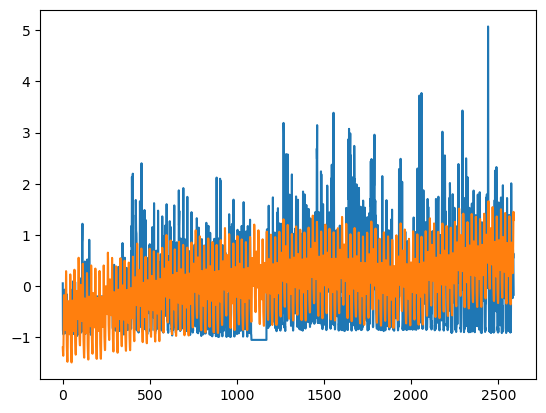

In [49]:
# Ensure forecast and gap_df_test have the same datetime index
aligned_df = pd.merge(forecast_gap[['ds', 'yhat']], gap_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])


## GRP Prediction

In [50]:
grp_df = df_train.copy()
grp_df.rename(columns={'Global_reactive_power':'y'}, inplace=True)
grp_df['ds'] = df_train.index
grp_df = grp_df.reset_index(drop=True)

In [51]:
grp_df_train = grp_df[:32000]
grp_df_test = grp_df[32000:]

In [52]:
model2 = Prophet()
model2.add_regressor('Global_active_power')
model2.add_regressor('Voltage')
model2.add_regressor('Global_intensity')
model2.add_regressor('Sub_metering_1')
model2.add_regressor('Sub_metering_2')
model2.add_regressor('Sub_metering_3')
model2.add_regressor('rem_consumption')

In [53]:
model2.fit(grp_df_train)

15:08:10 - cmdstanpy - INFO - Chain [1] start processing
15:08:24 - cmdstanpy - INFO - Chain [1] done processing


In [54]:
test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

In [55]:
cols = ['Global_active_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'rem_consumption']
for col in cols:
    new_pred = forecast_regressor(grp_df_train, col, 2589)
    test_pred[col] = new_pred

15:08:40 - cmdstanpy - INFO - Chain [1] start processing
15:08:47 - cmdstanpy - INFO - Chain [1] done processing
15:08:49 - cmdstanpy - INFO - Chain [1] start processing
15:09:01 - cmdstanpy - INFO - Chain [1] done processing
15:09:03 - cmdstanpy - INFO - Chain [1] start processing
15:09:09 - cmdstanpy - INFO - Chain [1] done processing
15:09:10 - cmdstanpy - INFO - Chain [1] start processing
15:09:14 - cmdstanpy - INFO - Chain [1] done processing
15:09:16 - cmdstanpy - INFO - Chain [1] start processing
15:09:19 - cmdstanpy - INFO - Chain [1] done processing
15:09:21 - cmdstanpy - INFO - Chain [1] start processing
15:09:25 - cmdstanpy - INFO - Chain [1] done processing
15:09:27 - cmdstanpy - INFO - Chain [1] start processing
15:09:35 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
forecast_grp = model2.predict(test_pred)

In [58]:
rmse = math.sqrt(mean_squared_error(forecast_grp['yhat'], grp_df_test['y']))

In [59]:
rmse

1.1364064362548325

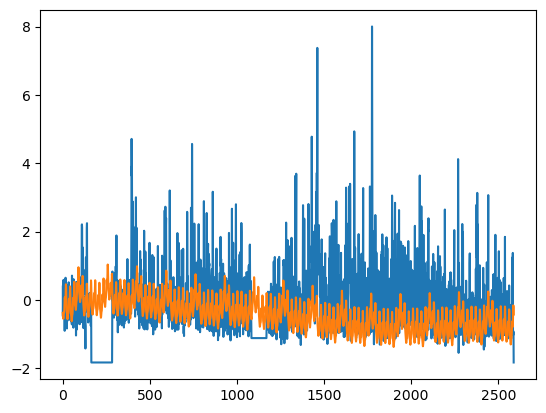

In [61]:
# Ensure forecast and gap_df_test have the same datetime index
aligned_df = pd.merge(forecast_grp[['ds', 'yhat']], grp_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])

## Voltage Prediction

15:10:26 - cmdstanpy - INFO - Chain [1] start processing
15:10:45 - cmdstanpy - INFO - Chain [1] done processing
15:10:46 - cmdstanpy - INFO - Chain [1] start processing
15:10:55 - cmdstanpy - INFO - Chain [1] done processing
15:10:56 - cmdstanpy - INFO - Chain [1] start processing
15:11:06 - cmdstanpy - INFO - Chain [1] done processing
15:11:08 - cmdstanpy - INFO - Chain [1] start processing
15:11:13 - cmdstanpy - INFO - Chain [1] done processing
15:11:15 - cmdstanpy - INFO - Chain [1] start processing
15:11:19 - cmdstanpy - INFO - Chain [1] done processing
15:11:21 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing
15:11:26 - cmdstanpy - INFO - Chain [1] start processing
15:11:30 - cmdstanpy - INFO - Chain [1] done processing
15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:41 - cmdstanpy - INFO - Chain [1] done processing


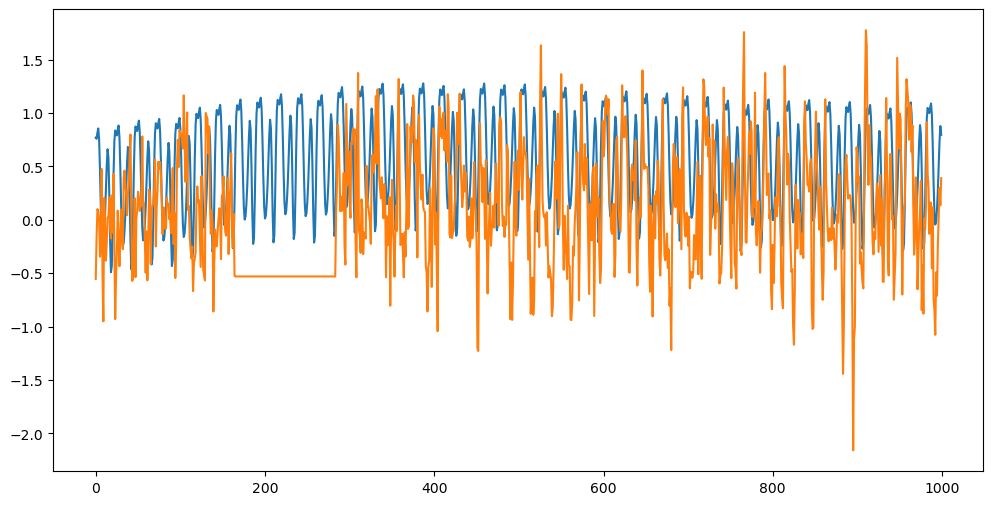

In [62]:
v_df = df_train.copy()
v_df.rename(columns={'Voltage':'y'}, inplace=True)
v_df['ds'] = df_train.index
v_df = v_df.reset_index(drop=True)

v_df_train = v_df[:32000]
v_df_test = v_df[32000:]

model3 = Prophet()
model3.add_regressor('Global_active_power')
model3.add_regressor('Global_reactive_power')
model3.add_regressor('Global_intensity')
model3.add_regressor('Sub_metering_1')
model3.add_regressor('Sub_metering_2')
model3.add_regressor('Sub_metering_3')
model3.add_regressor('rem_consumption')

model3.fit(v_df_train)

test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

cols = ['Global_active_power', 'Global_reactive_power',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'rem_consumption']
for col in cols:
    new_pred = forecast_regressor(v_df_train, col, 2589)
    test_pred[col] = new_pred
    
forecast_v = model3.predict(test_pred)

rmse = math.sqrt(mean_squared_error(forecast_v['yhat'], v_df_test['y']))

aligned_df = pd.merge(forecast_v[['ds', 'yhat']], v_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['yhat'][:])
plt.plot(aligned_df['y'][:])

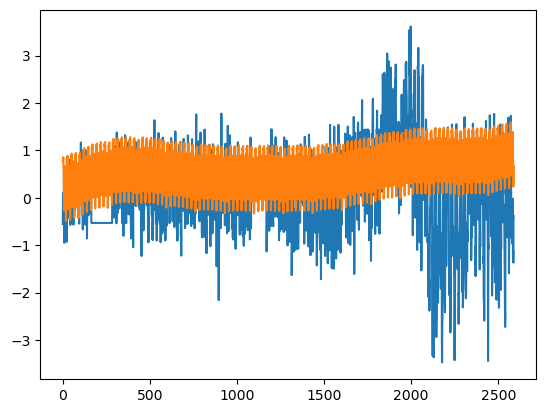

In [65]:
# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])

In [66]:
rmse

0.9706560652695208

## GI Prediction

15:12:52 - cmdstanpy - INFO - Chain [1] start processing
15:13:15 - cmdstanpy - INFO - Chain [1] done processing
15:13:17 - cmdstanpy - INFO - Chain [1] start processing
15:13:26 - cmdstanpy - INFO - Chain [1] done processing
15:13:28 - cmdstanpy - INFO - Chain [1] start processing
15:13:36 - cmdstanpy - INFO - Chain [1] done processing
15:13:38 - cmdstanpy - INFO - Chain [1] start processing
15:13:48 - cmdstanpy - INFO - Chain [1] done processing
15:13:49 - cmdstanpy - INFO - Chain [1] start processing
15:13:53 - cmdstanpy - INFO - Chain [1] done processing
15:13:55 - cmdstanpy - INFO - Chain [1] start processing
15:13:58 - cmdstanpy - INFO - Chain [1] done processing
15:13:59 - cmdstanpy - INFO - Chain [1] start processing
15:14:04 - cmdstanpy - INFO - Chain [1] done processing
15:14:05 - cmdstanpy - INFO - Chain [1] start processing
15:14:14 - cmdstanpy - INFO - Chain [1] done processing


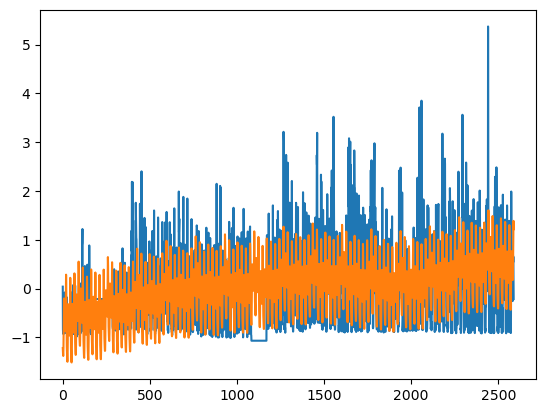

In [67]:
gi_df = df_train.copy()
gi_df.rename(columns={'Global_intensity':'y'}, inplace=True)
gi_df['ds'] = df_train.index
gi_df = gi_df.reset_index(drop=True)

gi_df_train = gi_df[:32000]
gi_df_test = gi_df[32000:]

model4 = Prophet()
model4.add_regressor('Global_active_power')
model4.add_regressor('Global_reactive_power')
model4.add_regressor('Voltage')
model4.add_regressor('Sub_metering_1')
model4.add_regressor('Sub_metering_2')
model4.add_regressor('Sub_metering_3')
model4.add_regressor('rem_consumption')

model4.fit(gi_df_train)

test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

cols = ['Global_active_power', 'Global_reactive_power',
       'Voltage', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'rem_consumption']
for col in cols:
    new_pred = forecast_regressor(gi_df_train, col, 2589)
    test_pred[col] = new_pred
    
forecast_gi = model4.predict(test_pred)

rmse = math.sqrt(mean_squared_error(forecast_gi['yhat'], gi_df_test['y']))

aligned_df = pd.merge(forecast_gi[['ds', 'yhat']], gi_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])

In [68]:
rmse

0.744565658558149

## Sub-metering 1 Prediction

15:14:49 - cmdstanpy - INFO - Chain [1] start processing
15:14:53 - cmdstanpy - INFO - Chain [1] done processing


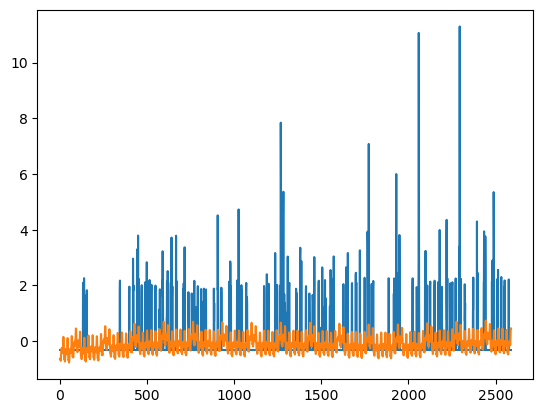

In [69]:
s1_df = df_train.copy()
s1_df.rename(columns={'Sub_metering_1':'y'}, inplace=True)
s1_df['ds'] = df_train.index
s1_df = s1_df.reset_index(drop=True)

s1_df_train = s1_df[:32000]
s1_df_test = s1_df[32000:]

model5 = Prophet()
# model5.add_regressor('Global_active_power')
# model5.add_regressor('Global_reactive_power')
# model5.add_regressor('Voltage')
# model5.add_regressor('Global_intensity')
# model5.add_regressor('Sub_metering_2')
# model5.add_regressor('Sub_metering_3')
# model5.add_regressor('rem_consumption')

model5.fit(s1_df_train)

test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

# cols = ['Global_active_power', 'Global_reactive_power',
#        'Voltage', 'Global_intensity', 'Sub_metering_2',
#        'Sub_metering_3', 'rem_consumption']
# for col in cols:
#     new_pred = forecast_regressor(s1_df_train, col, 4589)
#     test_pred[col] = new_pred
    
forecast_s1 = model5.predict(test_pred)

rmse = math.sqrt(mean_squared_error(forecast_s1['yhat'], s1_df_test['y']))

aligned_df = pd.merge(forecast_s1[['ds', 'yhat']], s1_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])

In [70]:
rmse

0.8402843535200721

## Sub-metering 2 Prediction

15:15:26 - cmdstanpy - INFO - Chain [1] start processing
15:15:29 - cmdstanpy - INFO - Chain [1] done processing


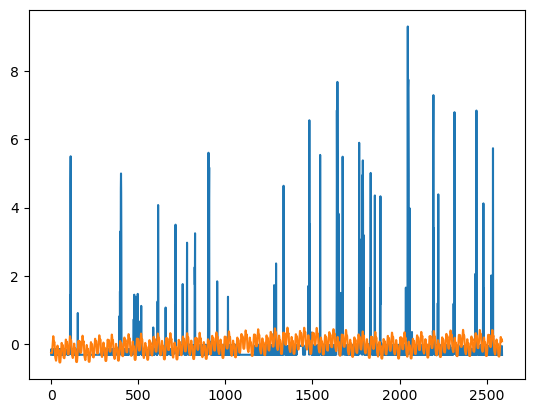

In [71]:
s2_df = df_train.copy()
s2_df.rename(columns={'Sub_metering_2':'y'}, inplace=True)
s2_df['ds'] = df_train.index
s2_df = s2_df.reset_index(drop=True)

s2_df_train = s2_df[:32000]
s2_df_test = s2_df[32000:]

model6 = Prophet()
# model5.add_regressor('Global_active_power')
# model5.add_regressor('Global_reactive_power')
# model5.add_regressor('Voltage')
# model5.add_regressor('Global_intensity')
# model5.add_regressor('Sub_metering_2')
# model5.add_regressor('Sub_metering_3')
# model5.add_regressor('rem_consumption')

model6.fit(s2_df_train)

test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

# cols = ['Global_active_power', 'Global_reactive_power',
#        'Voltage', 'Global_intensity', 'Sub_metering_2',
#        'Sub_metering_3', 'rem_consumption']
# for col in cols:
#     new_pred = forecast_regressor(s1_df_train, col, 4589)
#     test_pred[col] = new_pred
    
forecast_s2 = model6.predict(test_pred)

rmse = math.sqrt(mean_squared_error(forecast_s2['yhat'], s2_df_test['y']))

aligned_df = pd.merge(forecast_s2[['ds', 'yhat']], s2_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])

In [72]:
rmse

0.7952776946249122

## Sub-metering 3 Prediction

15:15:58 - cmdstanpy - INFO - Chain [1] start processing
15:16:03 - cmdstanpy - INFO - Chain [1] done processing


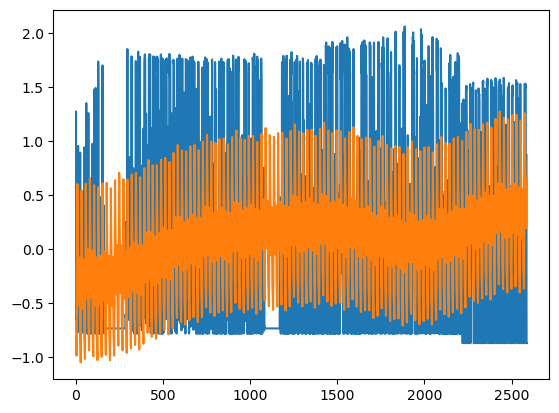

In [73]:
s3_df = df_train.copy()
s3_df.rename(columns={'Sub_metering_3':'y'}, inplace=True)
s3_df['ds'] = df_train.index
s3_df = s3_df.reset_index(drop=True)

s3_df_train = s3_df[:32000]
s3_df_test = s3_df[32000:]

model7 = Prophet()
# model5.add_regressor('Global_active_power')
# model5.add_regressor('Global_reactive_power')
# model5.add_regressor('Voltage')
# model5.add_regressor('Global_intensity')
# model5.add_regressor('Sub_metering_2')
# model5.add_regressor('Sub_metering_3')
# model5.add_regressor('rem_consumption')

model7.fit(s3_df_train)

test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

# cols = ['Global_active_power', 'Global_reactive_power',
#        'Voltage', 'Global_intensity', 'Sub_metering_2',
#        'Sub_metering_3', 'rem_consumption']
# for col in cols:
#     new_pred = forecast_regressor(s1_df_train, col, 4589)
#     test_pred[col] = new_pred
    
forecast_s3 = model7.predict(test_pred)

rmse = math.sqrt(mean_squared_error(forecast_s3['yhat'], s3_df_test['y']))

aligned_df = pd.merge(forecast_s3[['ds', 'yhat']], s3_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])

In [74]:
rmse

0.8675210736418252

## Remaining power consumption Prediction

15:16:31 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing


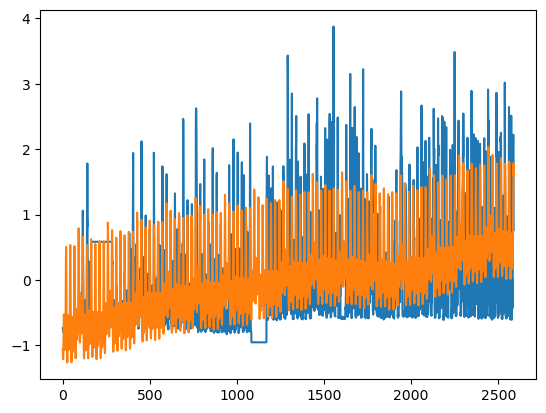

In [75]:
s4_df = df_train.copy()
s4_df.rename(columns={'rem_consumption':'y'}, inplace=True)
s4_df['ds'] = df_train.index
s4_df = s4_df.reset_index(drop=True)

s4_df_train = s4_df[:32000]
s4_df_test = s4_df[32000:]

model8 = Prophet()
# model5.add_regressor('Global_active_power')
# model5.add_regressor('Global_reactive_power')
# model5.add_regressor('Voltage')
# model5.add_regressor('Global_intensity')
# model5.add_regressor('Sub_metering_2')
# model5.add_regressor('Sub_metering_3')
# model5.add_regressor('rem_consumption')

model8.fit(s4_df_train)

test_pred = pd.DataFrame({
    'ds': pd.date_range(start='2010-08-11 01:00:00', periods=2589, freq='H') 
})

# cols = ['Global_active_power', 'Global_reactive_power',
#        'Voltage', 'Global_intensity', 'Sub_metering_2',
#        'Sub_metering_3', 'rem_consumption']
# for col in cols:
#     new_pred = forecast_regressor(s1_df_train, col, 4589)
#     test_pred[col] = new_pred
    
forecast_s4 = model8.predict(test_pred)

rmse = math.sqrt(mean_squared_error(forecast_s4['yhat'], s4_df_test['y']))

aligned_df = pd.merge(forecast_s4[['ds', 'yhat']], s4_df_test[['ds', 'y']], on='ds', how='inner')

# Plotting
plt.plot(aligned_df['y'][:])
plt.plot(aligned_df['yhat'][:])

In [76]:
rmse

0.7040032142027927

## Inverse scaling

In [77]:
final_pred_df = pd.DataFrame()
# final_pred_df['ds'] = gap_df_test['ds'].reset_index(drop=True)
final_pred_df['Global_active_power'] = forecast_gap['yhat'].reset_index(drop=True)
final_pred_df['Global_reactive_power'] = forecast_grp['yhat']
final_pred_df['Voltage'] = forecast_v['yhat']
final_pred_df['Global_intensity'] = forecast_gap['yhat']
final_pred_df['Sub_metering_1'] = forecast_s1['yhat']
final_pred_df['Sub_metering_2'] = forecast_s2['yhat']
final_pred_df['Sub_metering_3'] = forecast_s3['yhat']
final_pred_df['rem_consumption'] = forecast_s4['yhat']
final_pred_df = pd.DataFrame(scaler.inverse_transform(final_pred_df))


In [80]:
final_pred_df.columns = final_true_df.columns

In [79]:
final_true_df = raw_data[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'rem_consumption']][32000:]

In [81]:
final_true_df

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,rem_consumption
Datetime,,,,,,,,
2010-08-11 01:00:00,1.134933,0.092633,239.180667,4.750000,0.0,0.000000,15.750000,3.165556
2010-08-11 02:00:00,0.321600,0.151333,240.354333,1.473333,0.0,0.683333,1.650000,3.026667
2010-08-11 03:00:00,0.275767,0.089333,241.142667,1.200000,0.0,0.183333,1.666667,2.746111
2010-08-11 04:00:00,0.327000,0.162067,241.079333,1.530000,0.0,0.500000,1.633333,3.316667
2010-08-11 05:00:00,0.241133,0.102567,240.863500,1.100000,0.0,0.350000,0.650000,3.018889
...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,1.725900,0.061400,237.069667,7.216667,0.0,0.000000,12.866667,15.898333
2010-11-26 18:00:00,1.573467,0.053700,237.531833,6.620000,0.0,0.000000,0.000000,26.224444
2010-11-26 19:00:00,1.659333,0.060033,236.741000,7.056667,0.0,0.066667,0.000000,27.588889


## Calculating RMSE

In [82]:
col_preds = ['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'rem_consumption']
for col in col_preds:
    rmse = math.sqrt(mean_squared_error(final_pred_df[col], final_true_df[col]))
    print(f"RMSE for {col} = {rmse}")

RMSE for Global_active_power = 0.6705716999665399
RMSE for Global_reactive_power = 0.07638975817801455
RMSE for Voltage = 2.9110784595198744
RMSE for Global_intensity = 2.8142959829273084
RMSE for Sub_metering_1 = 2.9564959874459134
RMSE for Sub_metering_2 = 3.3152419308956484
RMSE for Sub_metering_3 = 6.371605817816943
RMSE for rem_consumption = 5.803897803431926
